## INF367 Mandatory Assignment 2

<p style="text-align:right;"><b>Written by:</b> Tobias Husebø, Lasse Holt, Martin Flo Øfstaas</p>
    <p style="text-align:right;"><i>Due: 8th of November 2024, (12:00)</i></p>

NB! look in notebook for more in-detail report

---

### Imports

We start of by declaring all imports used in the assignment.


In [53]:
# SKLEARN:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import log_loss

# QISKIT:
from qiskit import QuantumCircuit, transpile, assemble, ClassicalRegister
from qiskit_aer import QasmSimulator
from qiskit.quantum_info import Statevector
from qiskit.circuit import ParameterVector

# PANDAS:
import pandas as pd

# NUMPY:
import numpy as np

# MATPLOTLIB:
import matplotlib.pyplot as plt

# COPY
import copy as c

# RANDOM
import random as r

# TIME
import time as t

---

&nbsp;

### Data initialization:

We start of by initializing our dataset. We do this via sklearns `load_iris()`. Furthermore we wish to explore the entirety of the dataset and not only the training subset. There is a few reasons for this. Firstly, the dataset is already relatively small. This means that splitting it via `train_test_split()` may not provide a represenative view of its characteristics. Thus, data exploration on the training subset may yield skewed pictures of what the data actually looks like. Secondly, the iris dataset is well-known and most of us has already worked with it, meaning concerns about data leakage are minimal.

In [54]:
# Loading the dataset:
data = load_iris()
X = data.data
y = data.target

---

&nbsp;

### Data Exploration:

In our data exploration step, we start of by looking at some fundamental properties of the dataset. Namely, missing values, label distribution and more. This leads to valuable insight which in return may help us choose a preformance metric, which encoding to utilize and etc.

We start of by defining some functions for the data exploration:

In [55]:
features = data.feature_names
labels = data.target_names
num_datapoints = len(X)
num_dims = len(features)


# Print the counts of datapoints, dims and alike
def dataset_counts(X, y):
    out_string = f"\nThe dataset contains {num_datapoints} datapoints"
    out_string += f"\nThe dataset contains {len(features)} dimensions\n\n"
    
    for i in range(len(features)):
        out_string += f"Feature {i+1}: {features[i]}\n"
        out_string += f"Feature {i+1} value interval [{np.min(X[:,i])}, {np.max(X[:,i])}]\n\n"
    
    print(out_string)
    

# Print out missing values (if any)
def missing_values_dataset(X, y):
    missing_X = np.isnan(X).any()
    missing_y = np.isnan(y).any()
    
    if missing_X or missing_y:
        print("The dataset contains one or more missing values.")
    else:
        print("The dataset is complete.")
        
        
# Visualize label distribution
def feature_count_distribution(X):
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.ravel()  # Flatten the axes array for easy indexing

    # Plot each feature in a separate subplot
    for i in range(len(features)):
        axes[i].hist(X[:, i], bins=20, color='blue', alpha=0.7)
        axes[i].set_title(f'{features[i]} distribution')
        axes[i].set_xlabel('Value')
        axes[i].grid(axis="y")
        axes[i].set_ylabel('Frequency')
        
    fig.suptitle('Fig 1 - Distribution of Each Feature in Iris Dataset', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    
# Visualize label distribution
def label_distribution(y):
    _, counts = np.unique(y, return_counts=True)
    ticks = [label for label in labels]
    colors = plt.cm.tab10.colors[:len(counts)] 
    
    
    plt.bar(np.arange(len(counts)), counts, tick_label=ticks, color=colors)
    plt.xlabel('Each distinct label')
    plt.ylabel('Label count')
    plt.grid(axis="y")
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.title('Fig 2 - Distribution of Labels', fontsize=14, fontweight="bold")
    plt.show()

&nbsp;

After defining some functions we can utilize them to gain valuable insight:

In [56]:
dataset_counts(X, y)


The dataset contains 150 datapoints
The dataset contains 4 dimensions

Feature 1: sepal length (cm)
Feature 1 value interval [4.3, 7.9]

Feature 2: sepal width (cm)
Feature 2 value interval [2.0, 4.4]

Feature 3: petal length (cm)
Feature 3 value interval [1.0, 6.9]

Feature 4: petal width (cm)
Feature 4 value interval [0.1, 2.5]




In [57]:
missing_values_dataset(X, y)

The dataset is complete.


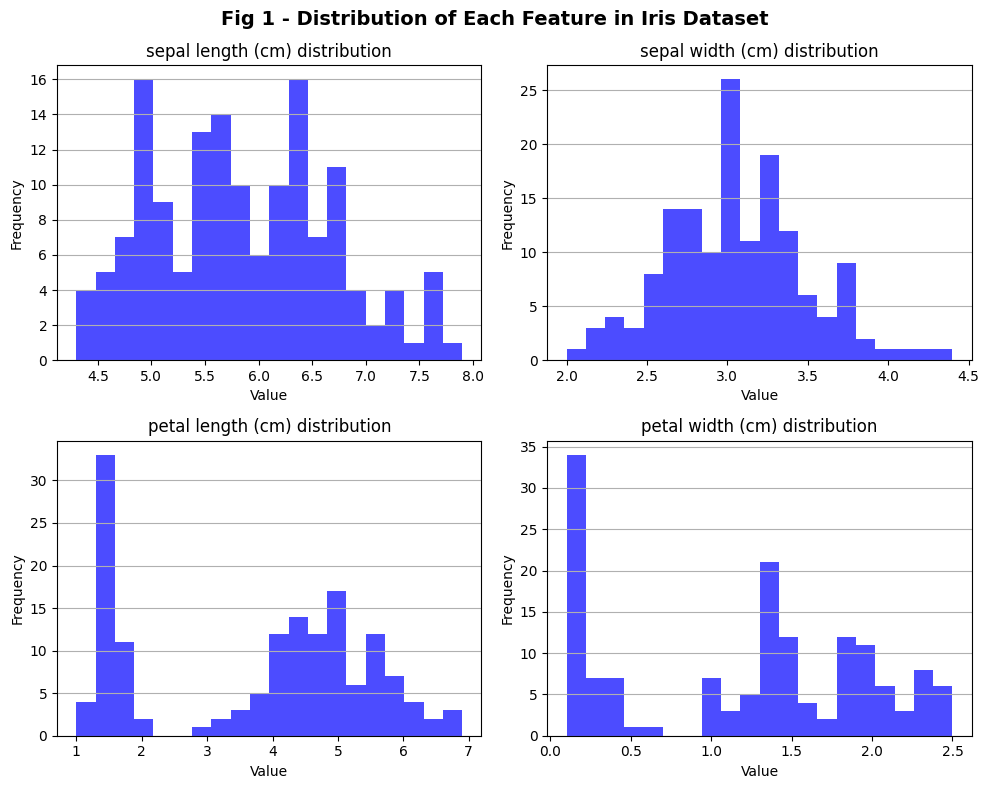

In [58]:
feature_count_distribution(X)

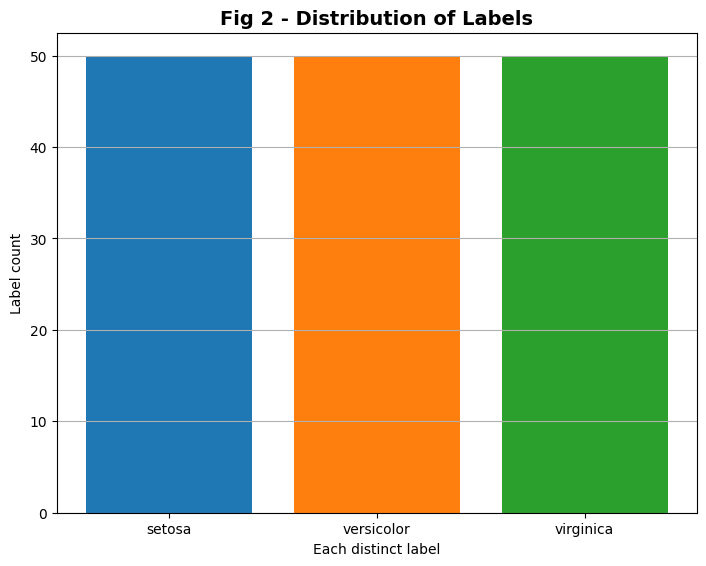

In [59]:
label_distribution(y)    

&nbsp;

After running our exploration functions we have gained some insight which will help us further on in the preprocessing / encoding step.

---

&nbsp;

### Data Preprocessing / Encoding:

#### PCA - Principal Component Analysis:

In our preprocessing stage we start of by visualizing the cumulative explained variance of each principal component, via the function `PCA_on_dataset(X):`

In [60]:
def PCA_on_dataset(X):
    # Initializing PCA object with seed for reproducibility:
    seed = 55
    pca = PCA(random_state=seed)
    pca.fit(X)
    
    # Visualize the cumulative variance:
    svs = pca.singular_values_
    expl_variance = pca.explained_variance_ratio_
    
    plt.plot(np.arange(1, len(svs)+1, 1), [sum(expl_variance[:i+1])*100 for i in range(len(expl_variance))])
    plt.yticks(np.arange(80, 101, 1))
    plt.xticks(np.arange(1,len(svs)+0.1, 1))
    plt.ylim(78, 102)
    plt.xlabel("Number of PCs")
    plt.ylabel("Cumulative explained variance (%)")
    plt.title('Fig 3 - PCA on Dataset', fontsize=14, fontweight="bold")
    plt.grid()
    
    plt.show()
    

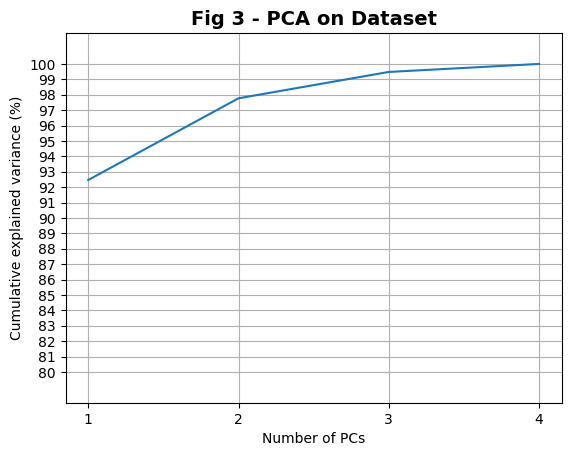

In [61]:
PCA_on_dataset(X)

Via looking at this it is clear that by utilizing only 2 of our 4 principal components we are able to capture `98%` of the information in the original dataset. Thus, we can simply project our datapoints on the axes´ formed by the first and second principal component to reduce the dimensionality and maintain almost all information in the dataset.

Thus, we reduce the dimensionality from 4 to 2 via `dim_reduction(X, num_PCs)`. Additionally, we can plot the data with `scatter_plot_2d_data(X, y)` to visualize that the first 2 PC´s capture most of the information:

In [62]:
def dim_reduction(X, num_PCs):
    # Initializing PCA object with seed for reproducibility:
    seed = 55
    pca = PCA(random_state=seed, n_components=2)
    return pca.fit_transform(X)

X_pca = dim_reduction(X, 2)

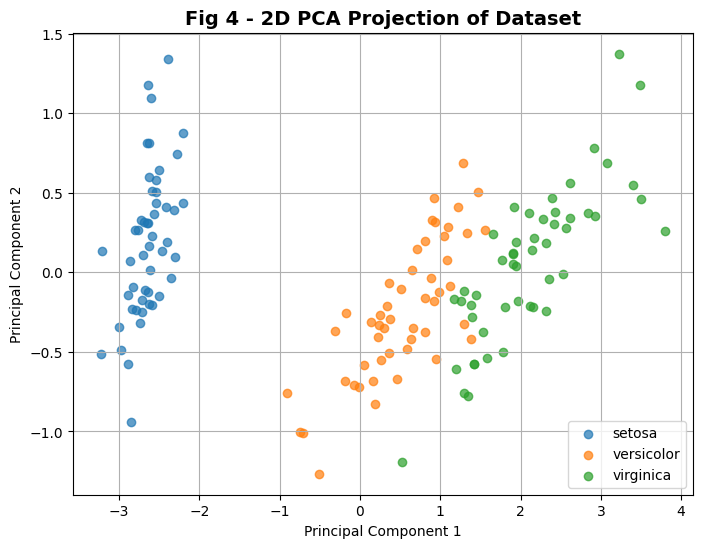

In [63]:
# Assuming `X` is the transformed data with 2 components and `y` contains the labels
def scatter_plot_2d_data(X, y, xlabel, ylabel, title, radian_ticks):
    # Define colors for each class
    colors = plt.cm.tab10.colors[:len(labels)] 
    labels_nr = [0, 1, 2]
    
    plt.figure(figsize=(8, 6))
    
    # Plot each class with a different color
    for i, label in enumerate(labels_nr):
        plt.scatter(X[y == label, 0], X[y == label, 1], 
                    color=colors[i], label=f'{labels[i]}', alpha=0.7)
        
    if radian_ticks == True:
        ticks = np.linspace(0, np.pi, 5)  # Adjust the number of ticks as needed
        tick_labels = [f"{i:.2f}π" for i in np.linspace(0, 1, 5)]  # Labels like "0π", "0.5π", "1.0π", etc.

        plt.xticks(ticks, tick_labels)
        plt.yticks(ticks, tick_labels)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title, fontsize=14, fontweight="bold")
    plt.legend()
    plt.grid()
    plt.show()

scatter_plot_2d_data(X_pca, y, "Principal Component 1", "Principal Component 2", "Fig 4 - 2D PCA Projection of Dataset", False)

&nbsp;

Now we have reduced the dimensionality of our datavector X, and furthermore plotted it. We can see from our plot that via applying PCA we have still retained most of the information in the original dataset as there appears clear clusters for each class.

---

&nbsp;

#### Scaling / Encoding:

In our implementation of the QNN we have concluded that angle encoding is the way to go for the dataset at hand. For further information on our choice look at the report. This means that we have to scale it on a scale from $ x \in [0, \pi]$ as information. Thus, we scale via sklearns `MinMaxScaler()` function. We also want to plot the data to see that we still have maintained the original "structure" of the dataset: 

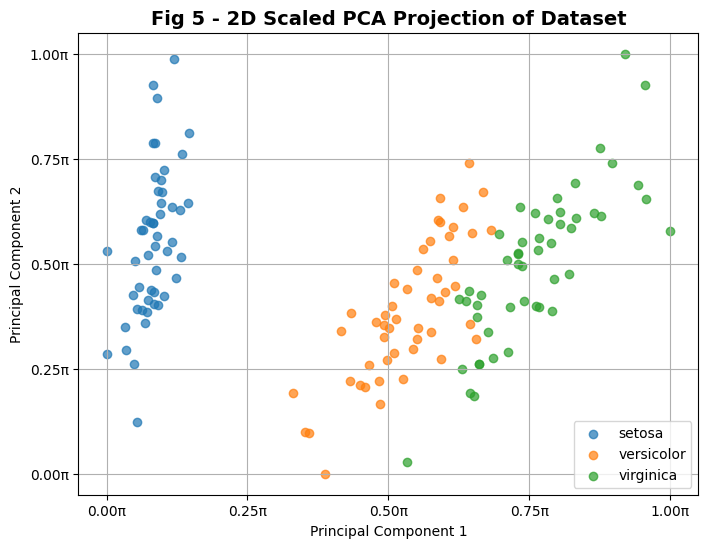

In [64]:
scaler = MinMaxScaler(feature_range=(0, np.pi))
X_pca_s = scaler.fit_transform(X_pca)
X = scaler.fit_transform(X)

scatter_plot_2d_data(X_pca_s, y, "Principal Component 1", "Principal Component 2", "Fig 5 - 2D Scaled PCA Projection of Dataset", True)

---

&nbsp;

#### Splitting the data:

After scaling the data, we can at last split it via sklearns `train_test_split()` function:

In [65]:
X_train_pca_s, X_val_test_pca_s, y_train_pca_s, y_val_test_pca_s = train_test_split(X_pca_s, y, test_size=0.30, random_state=55, stratify=y)
X_validation_pca_s, X_test_pca_s, y_validation_pca_s, y_test_pca_s = train_test_split(X_val_test_pca_s, y_val_test_pca_s, test_size=0.50, random_state=55, stratify=y_val_test_pca_s)

X_train, X_val_test, y_train, y_val_test = train_test_split(X, y, test_size=0.30, random_state=55, stratify=y)
X_validation, X_test, y_validation, y_test = train_test_split(X_val_test, y_val_test, test_size=0.50, random_state=55, stratify=y_val_test)

---

&nbsp;

### Model selection / Circuit creation

#### Circuit Creation

##### Circuit 1:

In the following code block we will define our first `IrisQNN_RealAmp` class which is a Quantum Neural Network "circuit" which is based on the circuit defined as Real Amplitudes by IBM.  

In [66]:
class IrisQNN_RealAmp:
    '''
    Class representing an implementation of the
    Real Amplitudes QNN.

    Attributes:
        - n_qubits (Int): Number of qubits in the QNN.
        - n_layers (Int): Number of layers to the variational part.
        - n_params (Int): Number of parameters to the variational layer(s).
        - params (ParameterVector): List of the actual parameters for the variational layer(s).
        - qc (QuantumCircuit): The actual QNN / Quantum circuit

    Functions:
        - create_circuit(): Creates the QNN
        - _angle_encoding(): Priv. func to angle encode datapoint. 
        - _add_variational_layer_real_amplitude(): Priv. func to add variational layer.
    '''
    
    def __init__(self, n_qubits, n_layers):
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.n_params = n_qubits * n_layers
        self.param_values = None
        self.params = None
        self.qc = None
        
        
    def create_circuit(self, input_features):
        '''
        A function for creating a Real Amp. circuit
        with the set parameters

        Parameters:
        - input_features (List[Float]): List of input_features to encode 
        
        Calls:
        - _angle_encoding()
        - _add_variational_layer_real_amplitude()
        '''
        # Initialize Quantum Circuit with new params and apply angle encoding:
        qc = QuantumCircuit(self.n_qubits)
        self.params = ParameterVector('θ', self.n_params)
        self._angle_encoding(qc, input_features)
        
        # For each layer, add a variational layer:
        for layer in range(self.n_layers):
            self._add_variational_layer_real_amplitude(qc, layer)
        
        # Add measurement in the end
        qc.measure_all()
        
        self.qc = qc
        
    
    def _angle_encoding(self, qc, input_features):
        '''
        A function to angle encode the qubits at init.
        of the Real Amp. circuit
        
        Parameters:
        - qc (QuantumCircuit): Circuit to apply encoding layer to
        - input_features(List[Float]): List of features to encode
        '''
        # For each qubit, add Rx-Gate for encoding
        for qubit in range(qc.num_qubits):
            qc.rx(input_features[qubit], qubit)
        qc.barrier()

    
    def _add_variational_layer_real_amplitude(self, qc, layer_idx):
        '''
        A function for applying a variational layer to
        the Real Amp. Circuit
               
        Parameters:
        - qc (QuantumCircuit): Circuit to apply var. layer to
        - layer_idx(Int): The index of the current layer
        '''
        # Param offset to shift to next layer
        param_offset = layer_idx * self.n_qubits
        
        # Add Ry-Gate to each qubit with set of params
        for i in range(self.n_qubits):
            qc.ry(self.params[param_offset + i], i)
        
        # Add CX-Gate for entanglement
        for i in range(self.n_qubits - 1):
            qc.cx(i, i+1)
            
        # Add barrier after each "variational" part:
        if layer_idx < self.n_layers - 1:
            qc.barrier()

    
    def get_parameter_count(self):
        '''Getter function for returning the parameter count'''
        return self.n_params
    

    
# Quick seethrough to see that we have managed to:
IrisQNN = IrisQNN_RealAmp(2,2)
IrisQNN.create_circuit([1,2])
IrisQNN.param_values = np.random.uniform(0, np.pi, 4)
IrisQNN.qc.assign_parameters({IrisQNN.params: IrisQNN.param_values},  inplace=True)

print(IrisQNN.param_values)
print(IrisQNN.qc)

[1.8884585  2.22447561 0.0646681  3.04706167]
        ┌───────┐ ░ ┌────────────┐      ░ ┌──────────────┐      ░ ┌─┐   
   q_0: ┤ Rx(1) ├─░─┤ Ry(1.8885) ├──■───░─┤ Ry(0.064668) ├──■───░─┤M├───
        ├───────┤ ░ ├────────────┤┌─┴─┐ ░ └┬────────────┬┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ Rx(2) ├─░─┤ Ry(2.2245) ├┤ X ├─░──┤ Ry(3.0471) ├─┤ X ├─░──╫─┤M├
        └───────┘ ░ └────────────┘└───┘ ░  └────────────┘ └───┘ ░  ║ └╥┘
meas: 2/═══════════════════════════════════════════════════════════╩══╩═
                                                                   0  1 


[0, 1]
2
3
[2, 3]
4
5


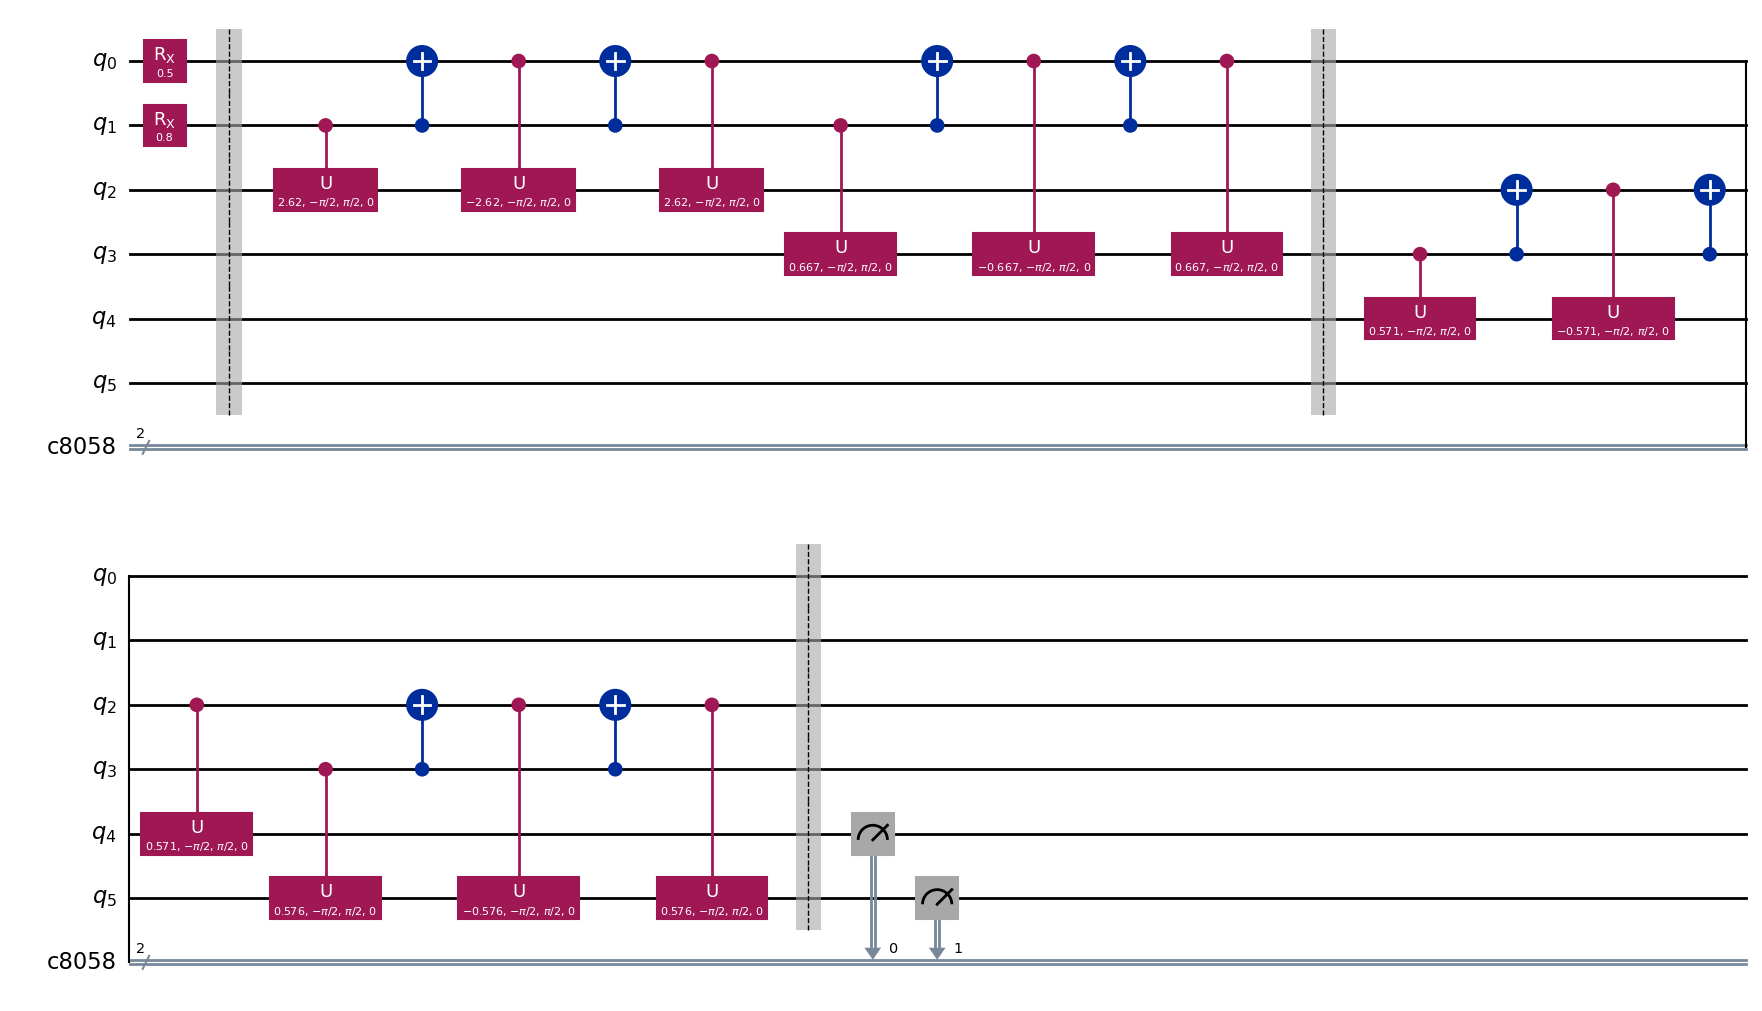

In [67]:
class QuantumFeedForwardNN:
    def __init__(self, n_qubits, n_layers, output_size, layer_size):
        """
        Initializes the Quantum Neural Network.
        
        Parameters:
        - n_qubits (int): Total number of qubits in the circuit.
        - n_layers (int): Number of layers in the network.
        - output_size (int): Number of qubits in the output layer.
        - layer_size (int): Number of qubits in each feed-forward layer.
        """
        self.n_qubits = n_qubits
        self.n_layers = n_layers
        self.layer_size = layer_size
        self.output_size = output_size
        self.n_params = n_qubits - layer_size
        self.param_values = None
        self.params = None
        self.qc = None
    
    def _angle_encoding(self, qc, input_features):
        """
        Encodes input features onto the first `len(input_features)` qubits using Rx gates.
        """
        num_encoded_qubits = len(input_features)
        for i in range(num_encoded_qubits):
            qc.rx(input_features[i], i)
        qc.barrier()

    def _add_feed_forward_layer(self, qc):
        """
        Adds a feed-forward layer with parameterized gates that transfer information to the next layer.
    
        Parameters:
        - qc (QuantumCircuit): The circuit to which the layer is added.
        - layer_idx (int): Index of the current layer.
       """
        param_index = 0
        # Apply parameterized controlled gates from each qubit in the current layer to the next layer's qubits
        for i in range(0, self.n_qubits-self.layer_size, self.layer_size):
            control_qubits = list(range(i, self.layer_size+i))
            print(control_qubits)
            for j in range(self.layer_size):
                target_qubit = (i + self.layer_size + j) # Choose the next qubit as target
                qc.mcrx(self.params[param_index], control_qubits , target_qubit)
                param_index += 1
                print(target_qubit)
            qc.barrier()
    
    def _add_output_layer(self, qc):
        """
        Adds the output layer to the circuit.
        """
        qc.add_register(ClassicalRegister(self.output_size))
        for i in range(self.n_qubits - self.output_size, self.n_qubits):
            qc.measure(i, i - (self.n_qubits - self.output_size))

    def create_circuit(self, input_features): 
        """
        Creates the Quantum Neural Network circuit.
        """
        qc = QuantumCircuit(self.n_qubits)
        self.params = ParameterVector('θ', self.n_params)
        self._angle_encoding(qc, input_features)
        self._add_feed_forward_layer(qc) 
        self._add_output_layer(qc)
        self.qc = qc

# Example usage
n_qubits = 6
n_layers = 3
output_size = 2
input_features = [0.5, 0.8]  # Example input features
layer_size = 2

qnn = QuantumFeedForwardNN(n_qubits, n_layers, output_size, layer_size)
qnn.create_circuit(input_features)
qnn.param_values = np.random.uniform(0, 2*np.pi, qnn.n_params)
qnn.qc.assign_parameters({qnn.params: qnn.param_values}, inplace=True) 
qnn.qc.draw('mpl')  # Visualize the circuit

&nbsp;

#### Training our Circuits:

In the following stage we will train our circuits. This training is conducted with regards to a specificed loss functions given to our "training" class. Below we will define our training class `train_QNN` which is utilized to train models in epochs and batches.

Firstly, we define our loss functions:

In [15]:
class Loss_functions:
    '''
    Class defining loss functions for usage in our training class
    
    Functions:
    - compute_loss_CE(): Loss function for computing Categorical Cross Entropy.
    '''
    
    #def compute_loss_CE(self, predicted, actual):
    #    '''Compute Categorical Cross Entropy Loss'''
    #    # Epsilon to ensure we never encounter log(0)
    #    eps = 1e-10
    #    return -np.sum([i*np.log(j if j != 0 else j+eps) for i,j in zip(actual, predicted)])
    
    def compute_loss_CE(self, predicted, actual):
        return log_loss(actual, predicted)

&nbsp;

Secondly, we define our loss training class:

In [16]:
class Train_QNN:
    '''
    A training class for training a given Quantum Neural Network
    given number of epochs and batches.
    
    Functions:
    - train(): Initializes a training session.
    - _exec_circuits():
    '''
    def __init__(self, X, y, X_val, y_val, QNN, loss_func, n_epochs, n_batches, patience = 3, momentum = 0.9):
        self.X = X
        self.y = y
        self.X_val = X_val
        self.y_val = y_val
        self.QNN = QNN
        self.loss_func = loss_func
        self.n_epochs = n_epochs
        self.n_batches = n_batches
        self.backend = QasmSimulator()
        np.random.seed(42)
        
        # Early stopping and momentum parameters
        self.patience = patience
        self.momentum = momentum
        self.best_val_loss = float('inf')
        self.best_params = None
        self.no_improvement_count = 0
        self.velocity = np.zeros_like(self.QNN.param_values)    
     
    
    
################################################## MAIN FUNCTIONS #################################################

    def train_single_datapoint_upd_new(self, shots=1000, learning_rate=0.1, eps=0.1):
        print(f"#### INITIALIZING TRAINING (single datapoint updates) #####")
        start_total = t.time()
        
        # Run n_batches for each epoch
        loss_list_train = np.zeros(self.n_epochs)
        loss_list_val = np.zeros(self.n_epochs)
        
        for epoch in range(self.n_epochs):
            start = t.time()
                
            #self.QNN.create_circuit(epoch)
            # Initialize start params 
            #if (epoch == 0):
            #    self._initialize_params()
            #else:
            #    self._set_params(self.QNN.param_values, False)
            #    
            #gradients = self._finiteDifference(eps, epoch)
            #self._update_param_vals(learning_rate=learning_rate, gradients=gradients)
            
            for batch in range(len(self.X)):
                self.QNN.create_circuit(self.X[batch])
                # Initialize start params 
                if (epoch == 0 and batch == 0):
                    self._initialize_params()
                else:
                    self._set_params(self.QNN.param_values, False)

                gradients = self._finiteDifference(eps, batch)
                self._update_param_vals(learning_rate=learning_rate, gradients=gradients)
                
            # Update loss at the end of each epoch & Early stopping check
            train_loss = self._train_loss(shots)
            loss_list_train[epoch] = train_loss
            
            val_loss = self._val_loss(shots)
            loss_list_val[epoch] = val_loss
            
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_params = self.QNN.param_values.copy()
                self.no_improvement_count = 0
            else:
                self.no_improvement_count += 1
            
            # Check if patience is exceeded
            if self.no_improvement_count >= self.patience:
                end = t.time()
                print(f"Early stopping at Epoch {epoch + 1} (Time used: {(end-start)/60:.2f} min)")
                print(f"Epoch stats:\n --- Training loss: {train_loss:.3f}\n --- Validation Loss: {val_loss:.3f}\n")
                break
            
            end = t.time()
            print(f"Epoch {epoch+1} Finished (Time used: {(end-start)/60:.2f} min)")
            print(f"Epoch stats:\n --- Training loss: {train_loss:.3f}\n --- Validation Loss: {val_loss:.3f}\n")
        
        
        end_total = t.time()
        print(f"Training finished! (Time used: {(end_total-start_total)/60:.2f} min)")
        print(f"#### TRAINING ENDED (single datapoint updates) ##### \n\n\n")
            
        return loss_list_train, loss_list_val
    
    
    
      
    def train_mini_batch_updates_new(self, shots=1000, learning_rate=0.1, eps=0.1,  batch_size=10, full_batch=False):
        if not full_batch:
            print(f"#### INITIALIZING TRAINING (mini batch updates) #####")
        else:
            print(f"#### INITIALIZING TRAINING (full batch updates) #####")
        start_total = t.time()
        # Run n_batches for each epoch
        loss_list_train = np.zeros(self.n_epochs)
        loss_list_val = np.zeros(self.n_epochs)
        
        for epoch in range(self.n_epochs):
            start = t.time()
            
            # Define batch size, shuffle and compute batches for each epoch
            indices_train = np.random.permutation(len(self.X))
            
            X_shuffled = self.X[indices_train]
            y_shuffled = self.y[indices_train]
            
            batches = [X_shuffled[i:i + batch_size] for i in range(0, len(X_shuffled), batch_size)]
            
            for batch_nr, batch in enumerate(batches):
                
                gradients = []
                for datapoint_idx, datapoint in enumerate(batch):
                    # Initialize QNN with current "input_values" for encoding:
                    self.QNN.create_circuit(datapoint)

                    # Initialize start params:
                    if (epoch == 0 and batch_nr == 0):
                        self._initialize_params()
                    else:
                        self._set_params(self.QNN.param_values, False)
                    
                    gradients.append(self._finiteDifference(eps, indices_train[(batch_nr*batch_size)+datapoint_idx]))
                
                avg_gradients = np.mean(gradients, axis=0)
                self._update_param_vals(learning_rate=learning_rate, gradients=avg_gradients)
                
                
            # Update loss at the end of each epoch & Early stopping check
            train_loss = self._train_loss(shots)
            loss_list_train[epoch] = train_loss
            
            val_loss = self._val_loss(shots)
            loss_list_val[epoch] = val_loss
            
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.best_params = self.QNN.param_values.copy()
                self.no_improvement_count = 0
            else:
                self.no_improvement_count += 1
            
            # Check if patience is exceeded
            if self.no_improvement_count >= self.patience:
                end = t.time()
                print(f"Early stopping at Epoch {epoch + 1} (Time used: {(end-start)/60:.2f} min)")
                print(f"Epoch stats:\n --- Training loss: {train_loss:.3f}\n --- Validation Loss: {val_loss:.3f}\n")
                break
            
            end = t.time()
            print(f"Epoch {epoch+1} Finished (Time used: {(end-start)/60:.2f} min)")
            print(f"Epoch stats:\n --- Training loss: {train_loss:.3f}\n --- Validation Loss: {val_loss:.3f}\n")
            
        end_total = t.time()
        print(f"\nTraining finished! (Time used: {(end_total-start_total)/60:.2f} min)")
        if not full_batch:
            print(f"#### TRAINING ENDED (mini batch updates) ##### \n\n\n")
        else:
            print(f"#### TRAINING ENDED (full batch updates) ##### \n\n\n")
            
        return loss_list_train, loss_list_val
    
    
    
    
    def train_full_batch_updates_new(self, shots=1000, learning_rate=0.1, eps=0.1):
        return self.train_mini_batch_updates_new(shots, learning_rate, eps, batch_size=len(self.X), full_batch=True)
    
    
    
################################################ HELPER FUNCTIONS #################################################

    def _train_loss(self, shots = 1000):
        train_loss = []
        for datapoint_idx, datapoint in enumerate(self.X):
            self.QNN.create_circuit(datapoint)
            self._set_params(self.QNN.param_values, True)
            actual, decoded_result = self._bin_decode(self._exec_circuit(shots=shots), datapoint_idx, shots, val=False)
            train_loss.append(self.loss_func.compute_loss_CE(decoded_result, actual))

        return np.mean(train_loss)


    def _val_loss(self, shots = 1000):
        val_loss = []
        for datapoint_idx, datapoint in enumerate(self.X_val):
            self.QNN.create_circuit(datapoint)
            self._set_params(self.QNN.param_values, True)
            actual, decoded_result = self._bin_decode(self._exec_circuit(shots=shots), datapoint_idx, shots, val=True)
            val_loss.append(self.loss_func.compute_loss_CE(decoded_result, actual))
            
        return np.mean(val_loss)
        
        
    def _initialize_params(self):
        init_params = np.random.uniform(0, np.pi, self.QNN.n_layers * self.QNN.n_qubits)
        self._set_params(init_params, False)
        
        
    def _set_params(self, params, grad_descent):
        if not grad_descent:
            self.QNN.param_values = params
        self.QNN.qc.assign_parameters({self.QNN.params: params}, inplace=True)
        
    #def _update_param_vals(self, gradients, learning_rate):
    #    self.QNN.param_values = self.QNN.param_values - (learning_rate * np.array(gradients))
    
    # New update func with momentum:
    def _update_param_vals(self, gradients, learning_rate):
        self.velocity = self.momentum * self.velocity + (1 - self.momentum) * np.array(gradients)
        self.QNN.param_values -= (learning_rate * self.velocity)
        
        
    def _exec_circuit(self, shots=1000):
        transpiled_qc = transpile(self.QNN.qc, self.backend)
        job = self.backend.run(transpiled_qc, shots=shots)
        return job.result()
    
    def _bin_decode(self, result, y_idx, shots=1000, val=False):
        counts = result.get_counts(self.QNN.qc)        # counts from the execution of the circuit
        probabilities = np.zeros(3)                    # array to store the probabilities of the classes

        for bitstring, count in counts.items():
            classIndex = int(bitstring, 2) % 3         # convert bitstring to integer 0, 1 or 2
            probabilities[classIndex] += count         # add the probability of the class

        probabilities /= np.sum(probabilities)         # Ensuring normalization
        actual = np.zeros(3)
        
        if not val:
            actual[self.y[y_idx]] = 1
        else:
            actual[self.y_val[y_idx]] = 1
        
        return actual, probabilities
    
    
    def _finiteDifference(self, epsilon, batch):
        # if (decode == binary and loss == CrossEntropy): 
        # Initialize list for holding gradients:
        gradients = []
        
        # Loop through all params and retrieve curr gradient:
        for i in range(self.QNN.n_params):
            forward, backward = np.copy(self.QNN.param_values), np.copy(self.QNN.param_values)
            forward[i], backward[i] = forward[i]-epsilon, backward[i]+epsilon
            
            self.QNN.create_circuit(X[batch])
            self._set_params(forward, True)
            actual, decoded_result = self._bin_decode(self._exec_circuit(shots=1000), batch)
            loss_forward = self.loss_func.compute_loss_CE(decoded_result, actual)
            
            self.QNN.create_circuit(X[batch])
            self._set_params(backward, True)            
            actual, decoded_result = self._bin_decode(self._exec_circuit(shots=1000), batch)
            loss_backward = self.loss_func.compute_loss_CE(decoded_result, actual)
            
            gradients.append((loss_forward - loss_backward) / (2 * epsilon))
        
        return gradients

&nbsp;

At last we make a loss visualization, search and iter function. These functions combined makes it easy for us to try different parameters for each and every type of update.

In [17]:
### VIZ LOSS ###
def remove_trailing_zeros(loss_list):
    # Find the index of the last non-zero element
    last_non_zero = len(loss_list) - 1
    while last_non_zero >= 0 and loss_list[last_non_zero] == 0:
        last_non_zero -= 1
    # Return the list up to the last non-zero element
    return loss_list[:last_non_zero + 1]

def visualize_loss(loss_list1, loss_list2, x_text, y_text, title, val_aswell = False):
    loss_list1 = remove_trailing_zeros(loss_list1)
    loss_list2 = remove_trailing_zeros(loss_list2)
    
    plt.figure(figsize=(12, 10))
    plt.plot(range(1, len(loss_list1) + 1), loss_list1, label="Training Loss", color="blue")
    plt.plot(range(1, len(loss_list2) + 1), loss_list2, label="Validation Loss", color="orange")
    plt.xlabel(x_text)
    plt.xticks(range(1, 41))
    plt.ylabel(y_text)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

In [18]:
def search_for_optimal_params(num_qubits = 2, num_layers = 2, learning_rate = 0.1):
    params_retrieved = {
        "mini_batch":[],
        "full_batch":[],
        "single_datapoint":[],
                       }
    
    x = num_qubits
    y = num_layers
    z = learning_rate
    name = f"Num_qubits: {x} num_layers: {y} learning_rate: {z}"
    
    if x == 2: # HUSK Å ADD Y_1, Y_2
        X_1, y_1, X_2, y_2 = X_train_pca_s, y_train_pca_s, X_validation_pca_s, y_validation_pca_s
    else:
        X_1, y_1, X_2, y_2 = X_train, y_train, X_validation, y_validation 
                    
    print(f"Current search:\nPARAMS: Qubits {x}, Layers {y}, Learning rate {z} \n\n")
    
    loss_func_cl = Loss_functions()
    myQNN = IrisQNN_RealAmp(x,y)
                
    print("###################################################################")
    print("#             TESTING TRAINING (single datapoint update):         #")
    print("###################################################################")
    trainer1 = Train_QNN(X_1, y_1, X_2, y_2, myQNN, loss_func_cl,
                         25, len(X_train), patience = 10, momentum = 0.9)
    loss_list_single_datapoint_train, loss_list_single_datapoint_val = trainer1.train_single_datapoint_upd_new(1000, z, 0.1)
    visualize_loss(np.array(loss_list_single_datapoint_train).flatten().tolist(),
                   np.array(loss_list_single_datapoint_val).flatten().tolist(),
                   "Epoch", "Loss", "Training Loss per Epoch (Single datapoint updates)")
                    
    print("###################################################################")
    print("#               TESTING TRAINING (minibatch updates):             #")
    print("###################################################################")
    trainer2 = Train_QNN(X_1, y_1, X_2, y_2, myQNN, loss_func_cl,
                         25, len(X_train), patience = 10, momentum = 0.9)
    loss_list_mini_batches_train, loss_list_mini_batches_val  = trainer2.train_mini_batch_updates_new(1000, z, 0.1, 10)
    visualize_loss(np.array(loss_list_mini_batches_train).flatten().tolist(),
                   np.array(loss_list_mini_batches_val).flatten().tolist(),
                   "Epoch", "Loss", "Training Loss per Epoch (Mini batches)")
                
                                                                                                              
    print("###################################################################")
    print("#               TESTING TRAINING (fullbatch updates):             #")
    print("###################################################################")
    trainer3 = Train_QNN(X_1, y_1, X_2, y_2, myQNN, loss_func_cl,
                         25, len(X_train), patience = 10, momentum = 0.9)
    loss_list_full_batches_train, loss_list_full_batches_val  = trainer3.train_full_batch_updates_new(1000, z, 0.1)
    visualize_loss(np.array(loss_list_full_batches_train).flatten().tolist(),
                   np.array(loss_list_full_batches_val).flatten().tolist(),
                   "Epoch", "Loss", "Training Loss per Epoch (Full batches)")
                                                                                                              
                
    params_retrieved["single_datapoint"].append((trainer1.best_val_loss, trainer1.best_params,
                                           loss_list_single_datapoint_train, loss_list_single_datapoint_val))
                
    params_retrieved["mini_batch"].append((trainer2.best_val_loss, trainer2.best_params,
                                           loss_list_mini_batches_train, loss_list_mini_batches_val))
                
    params_retrieved["full_batch"].append((trainer3.best_val_loss, trainer3.best_params,
                                           loss_list_full_batches_train, loss_list_full_batches_val))
                
                
    return x, y, name, params_retrieved
                

In [19]:
def iterate_params_retrieved(num_qubits, num_layers, name, params_retrieved):
    print(f"SEARCH OVER PARAMS: {name}")
    # Iterate over the keys of params_retrieved (e.g., 'mini_batch', 'full_batch', etc.)
    for batch_type, results_list in params_retrieved.items():
        print(f"\nResults for {batch_type} updates:")
        
        # Iterate over each entry in the results list
        for result in results_list:
            best_val_loss, best_params, train_loss, val_loss = result
            
            print(f"Best Validation Loss: {best_val_loss}")
            print(f"Best Params: {best_params}")
            print(f"Training Loss: {train_loss[-1]}")  # Printing last value as an example
            print(f"Validation Loss: {val_loss[-1]}")
            
            correct = 0
            num_possible_corr = len(y_test)
            backend = QasmSimulator()
            
            myQNN = IrisQNN_RealAmp(num_qubits, num_layers)

            for X,y in zip(X_test, y_test):
                    myQNN.create_circuit(X)
                    myQNN.qc.assign_parameters({myQNN.params: best_params}, inplace=True)
                    transpiled_qc = transpile(myQNN.qc, backend)
                    job = backend.run(transpiled_qc, shots=1000)

                    counts = job.result().get_counts(myQNN.qc) 
                    probabilities = np.zeros(3)                    

                    for bitstring, count in counts.items():
                        classIndex = int(bitstring, 2) % 3  
                        probabilities[classIndex] += count

                    probabilities /= np.sum(probabilities)
                    prediction = np.argmax(probabilities)

                    if prediction == y:
                        correct +=1

            print(f"Accuracy on test data: {correct/num_possible_corr}")

&nbsp;

At last we search:

In [20]:
num_qubits, num_layers, name_1, search_1 = search_for_optimal_params(num_qubits = 2, num_layers = 4, learning_rate = 0.1)
iterate_params_retrieved(num_qubits, num_layers, name_1, search_1)

Current search:
PARAMS: Qubits 2, Layers 4, Learning rate 0.1 


###################################################################
#             TESTING TRAINING (single datapoint update):         #
###################################################################
#### INITIALIZING TRAINING (single datapoint updates) #####
Epoch 1 Finished (Time used: 0.87 min)
Epoch stats:
 --- Training loss: 0.779
 --- Validation Loss: 0.749

Epoch 2 Finished (Time used: 0.86 min)
Epoch stats:
 --- Training loss: 1.007
 --- Validation Loss: 0.922

Epoch 3 Finished (Time used: 0.86 min)
Epoch stats:
 --- Training loss: 0.557
 --- Validation Loss: 0.559



KeyboardInterrupt: 